<a href="https://colab.research.google.com/github/sungbinlim/mge51101-instruct/blob/master/coursework/skeleton_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Skeleton code for CIFAR datasets

- use this code for the implementation of CIFAR dataloaders

In [2]:
!nvidia-smi
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)
import matplotlib.pyplot as plt

Thu Apr 23 10:13:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Model

- write your LeNet and AlexNet code in the following `MyCNN` class

In [0]:
# Number of classes
num_classes = 10

# Loss function & Optimizers
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

# Hyperparameters
num_epochs = 300
batch_size = 128
learning_rate = 0.001
weight_decay = 1e-4
lr_min = 0.1 * learning_rate


class MyAlexCNN(nn.Module):
    def __init__(self):
        super(MyAlexCNN, self).__init__()
        
        self.features = nn.Sequential(
                                      nn.Conv2d(3, 32, 3, stride=1, padding=0),
                                      nn.ReLU(),
                                      nn.MaxPool2d(3, stride=2),
                                      nn.Conv2d(32, 64, 3, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(3, stride=2),
                                      nn.Conv2d(64, 128, 3, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(128, 256, 3, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, 3, padding=0),
                                      nn.ReLU(),
                                      nn.MaxPool2d(3, stride=2),
        )
        self.classifier = nn.Sequential(
                                        nn.Flatten(),
                                        nn.Dropout(),
                                        nn.Linear(256, 512),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        nn.Linear(512, 256),
                                        nn.ReLU(),
                                        nn.Linear(256, num_classes)
        )



    def forward(self, inputs):

        """
        implement code here
        """
        
        hidden = self.features(inputs)
        shapes = hidden.size(1) * hidden.size(2) * hidden.size(3)
        hidden = hidden.view(hidden.size(0), shapes)
        outputs = self.classifier(hidden)
        return outputs

model = MyAlexCNN().cuda()

# Loss function & Optimizers
"""
you can change the loss and optimizer
"""
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# Hyperparameters
"""
you can change the value
"""
num_epochs = 200
batch_size = 128

## Training & Evaluation

- Don't change the below codes

In [4]:
import sys
sys.path.insert(0, "..")
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# CIFAR preprocessing 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# DataLoader for CIFAR-10
cifar_train = torchvision.datasets.CIFAR10(root="./", 
                                         train=True, 
                                         download=True,
                                         transform=transform_train
                                         )
cifar_test = torchvision.datasets.CIFAR10(root="./", 
                                        train=False, 
                                        download=True,
                                        transform=transform_test)


train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=4)

 
accuracy_graph = {'train-Alex':[], 'test-Alex':[], 'epoch': []}
loss_graph = {'train-Alex':[], 'test-Alex':[], 'epoch': []}

class accumulator():
    def __init__(self):
        self.cnt = 0
        self.obs = 0
        self.loss = 0

    def add(self, predict, output):

        assert len(predict) == len(output)

        self.cnt += self.count(predict, output).cpu().numpy()
        self.obs += len(predict)
    
    def count(self, predict, output):
        correct = torch.sum(torch.argmax(predict, dim=1) == output)
        
        return correct
        
    def loss_update(self, loss, batch_size):
        self.loss += loss * batch_size

    def running_stat(self):
        if self.obs != 0:
            run_acc = 100 * self.cnt / self.obs
            run_loss = self.loss / self.obs
        else: 
            run_acc = 0
            rum_loss = 0

        return run_acc, run_loss

    def reset(self):
        self.__init__()


for epoch in range(num_epochs):

    train_accuracy = accumulator()
    test_accuracy = accumulator()

    # Training
    for train_x, train_y in train_loader: 

        train_x, train_y = train_x.cuda(), train_y.cuda()
        train_predict = model(train_x)
        loss = criterion(train_predict, train_y)

        # Backpropagation        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy.add(train_predict, train_y)
        train_accuracy.loss_update(loss, batch_size)

    # Evaluation
    if epoch % 10 ==0:
             
        for test_x, test_y in test_loader:

            with torch.autograd.no_grad():
                test_x, test_y = test_x.cuda(), test_y.cuda()
                test_predict = model(test_x)
                test_accuracy.add(test_predict, test_y)

            loss_test = criterion(test_predict, test_y)
            test_accuracy.loss_update(loss_test, batch_size)

        train_acc, train_loss = train_accuracy.running_stat()
        test_acc, test_loss = test_accuracy.running_stat()
        accuracy_graph['train-Alex'].append(train_acc)
        accuracy_graph['test-Alex'].append(test_acc) 
        accuracy_graph['epoch'].append(epoch)
        loss_graph['train-Alex'].append(train_loss)
        loss_graph['test-Alex'].append(test_loss)
        loss_graph['epoch'].append(epoch)
        
        print("\ntrain accuracy: {:.2f} %, test accuracy: {:.2f} %".format(train_acc, test_acc))
        print("epoch:{}, train_loss: {:.4f}, test_loss: {:.4f}".format(epoch+1, train_loss, test_loss)) 

        train_accuracy.reset(), test_accuracy.reset()



Files already downloaded and verified
Files already downloaded and verified

train accuracy: 26.28 %, test accuracy: 38.21 %
epoch:1, train_loss: 1.8692, test_loss: 1.6628

train accuracy: 74.72 %, test accuracy: 74.52 %
epoch:11, train_loss: 0.7579, test_loss: 0.7776

train accuracy: 79.97 %, test accuracy: 78.60 %
epoch:21, train_loss: 0.6044, test_loss: 0.6687

train accuracy: 82.34 %, test accuracy: 79.29 %
epoch:31, train_loss: 0.5315, test_loss: 0.6444

train accuracy: 84.04 %, test accuracy: 81.24 %
epoch:41, train_loss: 0.4792, test_loss: 0.6073

train accuracy: 85.09 %, test accuracy: 80.28 %
epoch:51, train_loss: 0.4464, test_loss: 0.6374

train accuracy: 86.09 %, test accuracy: 81.98 %
epoch:61, train_loss: 0.4204, test_loss: 0.5917

train accuracy: 86.87 %, test accuracy: 82.91 %
epoch:71, train_loss: 0.4007, test_loss: 0.5949

train accuracy: 87.15 %, test accuracy: 82.87 %
epoch:81, train_loss: 0.3924, test_loss: 0.5617

train accuracy: 87.74 %, test accuracy: 82.62 %
epo

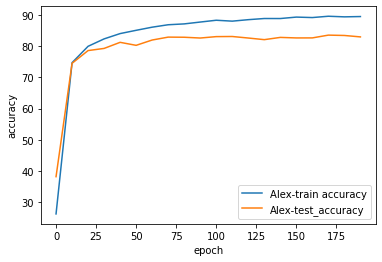

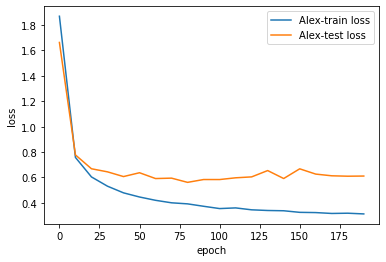

In [5]:

plt.plot(accuracy_graph['epoch'], accuracy_graph['train-Alex'], label = "Alex-train accuracy");
plt.plot(accuracy_graph['epoch'], accuracy_graph['test-Alex'], label = "Alex-test_accuracy");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

plot_loss_train = plt.plot(loss_graph['epoch'], loss_graph['train-Alex'], label="Alex-train loss");
plt.plot(loss_graph['epoch'], loss_graph['test-Alex'], label="Alex-test loss");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [0]:
# Number of classes
num_classes = 10

class MyLenetCNN(nn.Module):
    def __init__(self):
        super(MyLenetCNN, self).__init__()
        """
        implement code here
        """
     
        self.features = nn.Sequential(
                                      nn.Conv2d(3, 6, kernel_size=5),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2),
                                      nn.Conv2d(6, 16, kernel_size=5),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
                                        nn.Linear(16*5*5, 120),
                                        nn.ReLU(),
                                        nn.Linear(120, 84),
                                        nn.ReLU(),
                                        nn.Linear(84, num_classes)
        )

    def forward(self, inputs):

        """
        implement code here
        """
        
        hidden = self.features(inputs)
        shapes = hidden.size(1) * hidden.size(2) * hidden.size(3)
        hidden = hidden.view(hidden.size(0), shapes)
        outputs = self.classifier(hidden)
        return outputs

model = MyLenetCNN().cuda()

# Loss function & Optimizers
"""
you can change the loss and optimizer
"""
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# Hyperparameters
"""
you can change the value
"""
num_epochs = 200
batch_size = 128

In [7]:

 
accuracy_graph_Le = {'train':[], 'test':[], 'epoch': []}
loss_graph_Le = {'train':[], 'test':[], 'epoch': []}

for epoch in range(num_epochs):

    train_accuracy = accumulator()
    test_accuracy = accumulator()

    # Training
    for train_x, train_y in train_loader: 

        train_x, train_y = train_x.cuda(), train_y.cuda()
        train_predict = model(train_x)
        loss = criterion(train_predict, train_y)

        # Backpropagation        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy.add(train_predict, train_y)
        train_accuracy.loss_update(loss, batch_size)

    # Evaluation
    if epoch % 10 ==0:
             
        for test_x, test_y in test_loader:

            with torch.autograd.no_grad():
                test_x, test_y = test_x.cuda(), test_y.cuda()
                test_predict = model(test_x)
                test_accuracy.add(test_predict, test_y)

            loss_test = criterion(test_predict, test_y)
            test_accuracy.loss_update(loss_test, batch_size)

        train_acc, train_loss = train_accuracy.running_stat()
        test_acc, test_loss = test_accuracy.running_stat()
        accuracy_graph_Le['train'].append(train_acc)
        accuracy_graph_Le['test'].append(test_acc) 
        accuracy_graph_Le['epoch'].append(epoch)
        loss_graph_Le['train'].append(train_loss)
        loss_graph_Le['test'].append(test_loss)
        loss_graph_Le['epoch'].append(epoch)
        
        print("\ntrain accuracy: {:.2f} %, test accuracy: {:.2f} %".format(train_acc, test_acc))
        print("epoch:{}, train_loss: {:.4f}, test_loss: {:.4f}".format(epoch+1, train_loss, test_loss)) 

        train_accuracy.reset(), test_accuracy.reset()




train accuracy: 33.82 %, test accuracy: 44.24 %
epoch:1, train_loss: 1.7879, test_loss: 1.5476

train accuracy: 59.19 %, test accuracy: 61.78 %
epoch:11, train_loss: 1.1522, test_loss: 1.0792

train accuracy: 62.91 %, test accuracy: 65.32 %
epoch:21, train_loss: 1.0479, test_loss: 0.9993

train accuracy: 64.91 %, test accuracy: 67.64 %
epoch:31, train_loss: 0.9927, test_loss: 0.9433

train accuracy: 66.57 %, test accuracy: 69.13 %
epoch:41, train_loss: 0.9518, test_loss: 0.9010

train accuracy: 66.89 %, test accuracy: 70.06 %
epoch:51, train_loss: 0.9355, test_loss: 0.8823

train accuracy: 67.78 %, test accuracy: 70.14 %
epoch:61, train_loss: 0.9116, test_loss: 0.8722

train accuracy: 68.08 %, test accuracy: 70.31 %
epoch:71, train_loss: 0.9030, test_loss: 0.8578

train accuracy: 68.63 %, test accuracy: 70.45 %
epoch:81, train_loss: 0.8900, test_loss: 0.8649

train accuracy: 69.24 %, test accuracy: 71.35 %
epoch:91, train_loss: 0.8726, test_loss: 0.8303

train accuracy: 69.83 %, test 

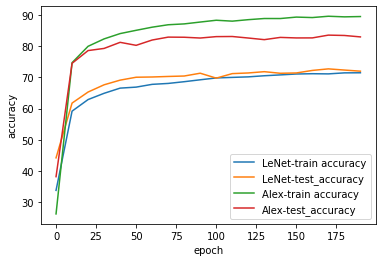

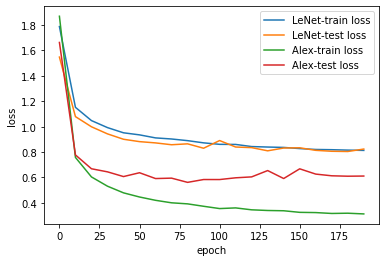

In [8]:


# Plot loss curve
plt.plot(accuracy_graph_Le['epoch'], accuracy_graph_Le['train'], label = "LeNet-train accuracy");
plt.plot(accuracy_graph_Le['epoch'], accuracy_graph_Le['test'], label = "LeNet-test_accuracy");
plt.plot(accuracy_graph['epoch'], accuracy_graph['train-Alex'], label = "Alex-train accuracy");
plt.plot(accuracy_graph['epoch'], accuracy_graph['test-Alex'], label = "Alex-test_accuracy");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

plot_loss_train = plt.plot(loss_graph_Le['epoch'], loss_graph_Le['train'], label="LeNet-train loss");
plt.plot(loss_graph_Le['epoch'], loss_graph_Le['test'], label="LeNet-test loss");
plt.plot(loss_graph['epoch'], loss_graph['train-Alex'], label="Alex-train loss");
plt.plot(loss_graph['epoch'], loss_graph['test-Alex'], label="Alex-test loss");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()